In [1]:
#Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
from PIL import Image
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

try:
    import cust_f
except:
    pass
# to perform multiprocessing using a customized function (not necessary for Linux)

tot_run_time_start = time.time()

In [2]:
plt.style.use('default')

mpl.rcParams['axes.unicode_minus'] = False

# Matplotlib fontsize change
SMALL_SIZE = 15
MEDIUM_SIZE = 20
LARGE_SIZE = 25

plt.rc('font', size=SMALL_SIZE, weight='bold')
plt.rc('axes', titlesize=LARGE_SIZE, titleweight='bold')
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')
plt.rc('axes', titleweight='bold')
plt.rc('xtick', labelsize=LARGE_SIZE)
plt.rc('ytick', labelsize=MEDIUM_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=LARGE_SIZE)

# Save figure settings
high_dpi = 300
fig_file_ext = '.png'
Image.MAX_IMAGE_PIXELS = None  # Ignore DecompressionBombError

In [3]:
with open("../btc_usd_1d.pkl", "rb") as f:
    df = pickle.load(f)
    df.rename(inplace=True, columns={'o': 'Open', 'h': 'High', 'l':'Low', 'c': 'Close', 'v': 'Volume'})
    df.index.name = 'Datetime'
    df['Datetime'] = df.index

In [4]:
df

,Open,High,Low,Close,Volume,Datetime
Datetime,,,,,,
2017-01-01,966.34,1005.00,960.53,998.80,6.579904e+06,2017-01-01
2017-01-02,997.75,1032.00,990.01,1014.10,8.190255e+06,2017-01-02
2017-01-03,1011.44,1039.00,999.99,1036.99,8.955193e+06,2017-01-03
2017-01-04,1035.51,1139.89,1028.56,1122.56,2.325716e+07,2017-01-04
2017-01-05,1114.38,1136.72,885.41,994.02,3.503690e+07,2017-01-05
...,...,...,...,...,...,...
2022-05-12,29077.90,30257.00,26631.00,29020.70,9.644756e+05,2022-05-12
2022-05-13,29020.80,31072.60,28730.40,29274.30,5.076201e+05,2022-05-13
2022-05-14,29274.20,30352.20,28602.30,30079.80,3.157569e+05,2022-05-14


In [5]:
y = df['Close']
y_1diff = df['Close'].diff().dropna()
result = adfuller(y)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}')
result = adfuller(y_1diff)
print(f'1차 차분 ADF Statistic: {result[0]:.3f}')
print(f'1차 차분 p-value: {result[1]:.3f}')

원 데이터 ADF Statistic: -1.344
원 데이터 p-value: 0.609
1차 차분 ADF Statistic: -7.455
1차 차분 p-value: 0.000


In [6]:
def backtest_ma(test_df):
    df = test_df.copy()
    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return df


def backtest_noise(test_df):
    noise_ma = 30
    df = test_df.copy()
    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return df


def backtest_rsi(test_df):
    df = test_df.copy()
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi
    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rsi_shift_1'] > 40), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, df['Close'] / df['Open'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return df


def backtest_ma_and_noise(test_df):
    noise_ma = 30
    df = test_df.copy()
    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()

    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 10

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return df


def backtest_ma_and_rsi(test_df):
    df = test_df.copy()
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi

    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0) & (df['rsi_shift_1'] > 40), 1, 0)  # rsi가 40이상일 경우에만 거래 진행
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100

    return df


def backtest_noise_and_rsi(test_df):
    df = test_df.copy()
    noise_ma = 30
    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi

    df['rate'] = 0
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0) & (df['rsi_shift_1'] > 40), 1, 0)  # rsi가 40이상일 경우에만 거래 진행
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100

    return df


def backtest_ma_and_rsi_and_noise(test_df):
    noise_ma = 30
    df = test_df.copy()
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi

    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()
    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 10

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0) & (df['rsi_shift_1'] > 40), 1, 0)  # rsi가 40이상일 경우에만 거래 진행
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100

    return df

In [18]:
def my_auto_arima(data, order, sort='AIC'):
    order_list = []
    aic_list = []
    bic_list = []

    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                     pass

    result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
    result_df.sort_values(sort, inplace=True)
    return result_df

In [19]:
model = ARIMA(df['Close'], order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())
# model_fit.plot_predict()
# plt.show()

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2614
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -21117.002
Date:                Thu, 05 May 2022   AIC                          42244.004
Time:                        21:36:03   BIC                          42273.345
Sample:                    11-29-2014   HQIC                         42254.632
                         - 01-24-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0991      0.166      6.623      0.000       0.774       1.424
ar.L2         -0.1810      0.161     -1.122      0.262      -0.497       0.135
ma.L1         -1.1409      0.164     -6.940      0.0

In [7]:
def batch(iterable, batch_size, pt):
    """
    batch row 생성 이터레이터
    Args:
        iterable: iterable datastructure
        batch_size:
        pt: prediction term 예측 기간
    Returns:
        yield: batch row
    """

    l = len(iterable)
    for idx, ndx in tqdm(enumerate(range(0, l, pt))):
        yield idx, iterable[ndx: min(ndx + batch_size, l)]


def backtest_ma(test_df):
    df = test_df.copy()
    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return df


def backtest_ma_and_noise(test_df):
    noise_ma = 30
    df = test_df.copy()
    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()

    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])

    df['rate'] = df['rate'] / 10

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return df


def backtest_ma_and_rsi(test_df):
    df = test_df.copy()
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi

    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0) & (df['rsi_shift_1'] > 40), 1, 0)  # rsi가 40이상일 경우에만 거래 진행
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100

    return df

def backtest_arima_1h(test_df: pd.DataFrame, ft: int, pt: int, arima_params=(2, 1, 2), plot=True) -> pd.DataFrame:
    """

    Args:
        test_df: 1시간 봉 데이터
        ft: fitting term 피팅 시킬 기간
        pt: prediction term 예측 기간
        arima_params:
    Returns:
        df: 예측 값이 열로 포함된 DataFrame
    """
    df = test_df.copy()
    df.index = pd.to_datetime(df.Datetime)
    batch_size = ft + pt
    # total_loop = int(len(df) / pt) - 1
    result_columns = list(df.columns)
    result_columns.append("prediction_close")

    result_df = pd.DataFrame(columns=result_columns)

    try:
        for idx, batch_df in batch(df, batch_size, pt):
            # print(f'{idx}/{total_loop} running loop...')
            train, test = batch_df[:ft][['Close']], batch_df[ft:][['Close']]
            model = ARIMA(train, order=arima_params)
            model_fit = model.fit()
            full_forecast = model_fit.forecast(steps=pt)
            row = batch_df.iloc[[-1]]
            row['prediction_close'] = full_forecast[-1]
            row['batch_open'] = batch_df.iloc[ft].Open
            result_df = pd.concat([result_df, row], axis=0)

    except IndexError:
        pass

    result_df['trade'] = np.where(result_df['batch_open'] < result_df['prediction_close'], 1, 0)
    result_df['ror'] = np.where(result_df['trade'] == 1, result_df['Close'] / result_df['batch_open'], 1)
    result_df['cr'] = result_df['ror'].cumprod()
    result_df['mdd'] = (result_df['cr'].cummax() - result_df['cr']) / result_df['cr'].cummax() * 100

    if plot:
        plot_result(result_df)
        plot_return(result_df)

    return result_df

def plot_result(df):
    plt.figure(figsize=(20, 8))
    plt.plot(df.index, df['Close'].values, color='b', label='real close')
    plt.plot(df.index, df['prediction_close'].values , color='r', label='prediction close')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_return(df):
    plt.figure(figsize=(20, 8))
    plt.plot(df.index, df['cr'].values , color='r', label='return')
    plt.legend()
    plt.title(
        f"mdd: {round(df['mdd'].max(), 2)}\nreturn_rate: {round(df['cr'].iloc[-1] * 100 - 100, 2)}%")
    plt.grid(True)
    plt.show()


def analysis_return(test_df):
    # ror: 일일 수익률
    # trading_rate: 거래 확률
    # success_rate: 거래 성공 확률
    # pnl_rate: 손익비
    # mdd: 최대 손실 낙폭
    # cr: 누적 수익률

    df = test_df.copy()
    df['success'] = np.where((df['ror'] > 1) & (df['trade'] == 1), 1, 0)
    df['fail'] = np.where((df['ror'] < 1) & (df['trade'] == 1), 1, 0)
    df['success_ror'] = np.where(df['success'], (df['ror'] - 1) * 100, 0)
    df['fail_ror'] = np.where(df['fail'], (1 - df['ror']) * 100, 0)

    trade_rate = df['trade'].sum() / len(df)
    success_rate = df['success'].sum() / df['trade'].sum()
    pnl_rate = df['success_ror'].sum() / df['fail_ror'].sum()
    mdd = df['mdd'].max()
    cr = df['cr'].iloc[-1]

    return_dict = {}
    return_dict['trade_rate'] = f'{trade_rate * 100: .2f}%'
    return_dict['success_rate'] = f'{success_rate * 100: .2f}%'
    return_dict['pnl_rate'] = f'{pnl_rate: .2f}'
    return_dict['mdd'] = f'{mdd: .2f}%'
    return_dict['cr'] = f'{(cr - 1) * 100: .2f}%'

    return return_dict

In [42]:
def get_result_loss_1(test_df):
    df = test_df.copy()
    df = df[(df.index >= "2021-05-10") & (df.index <= "2021-07-21")]
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return analysis_return(df)



def get_result_loss_2(test_df):
    df = test_df.copy()
    df = df[(df.index >= "2021-11-18") & (df.index <= "2022-02-06")]
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return analysis_return(df)



def get_result_profit_1(test_df):
    df = test_df.copy()
    df = df[(df.index >= "2019-02-17") & (df.index <= "2019-07-15")]
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return analysis_return(df)


def get_result_profit_2(test_df):
    df = test_df.copy()
    df = df[(df.index >= "2020-10-08") & (df.index <= "2021-04-17")]
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return analysis_return(df)

In [37]:
with open("../btc_usd_1d_long.pkl", "rb") as f:
    df = pickle.load(f)
    df.rename(inplace=True, columns={'o': 'Open', 'h': 'High', 'l': 'Low', 'c': 'Close', 'v': 'Volume'})
    df.index.name = 'Datetime'
    df['Datetime'] = df.index

In [ ]:
result_df = backtest_arima_1h(df, 100, 1)

933it [02:10,  7.64it/s]

In [38]:
get_result_loss_1(result_df)

{'trade_rate': ' 57.05%',
 'success_rate': ' 61.18%',
 'pnl_rate': ' 1.51',
 'mdd': ' 18.93%',
 'cr': ' 49.33%'}

In [24]:
analysis_return(result_df)

{'trade_rate': ' 50.68%',
 'success_rate': ' 51.40%',
 'pnl_rate': ' 1.09',
 'mdd': ' 71.80%',
 'cr': ' 45.42%'}

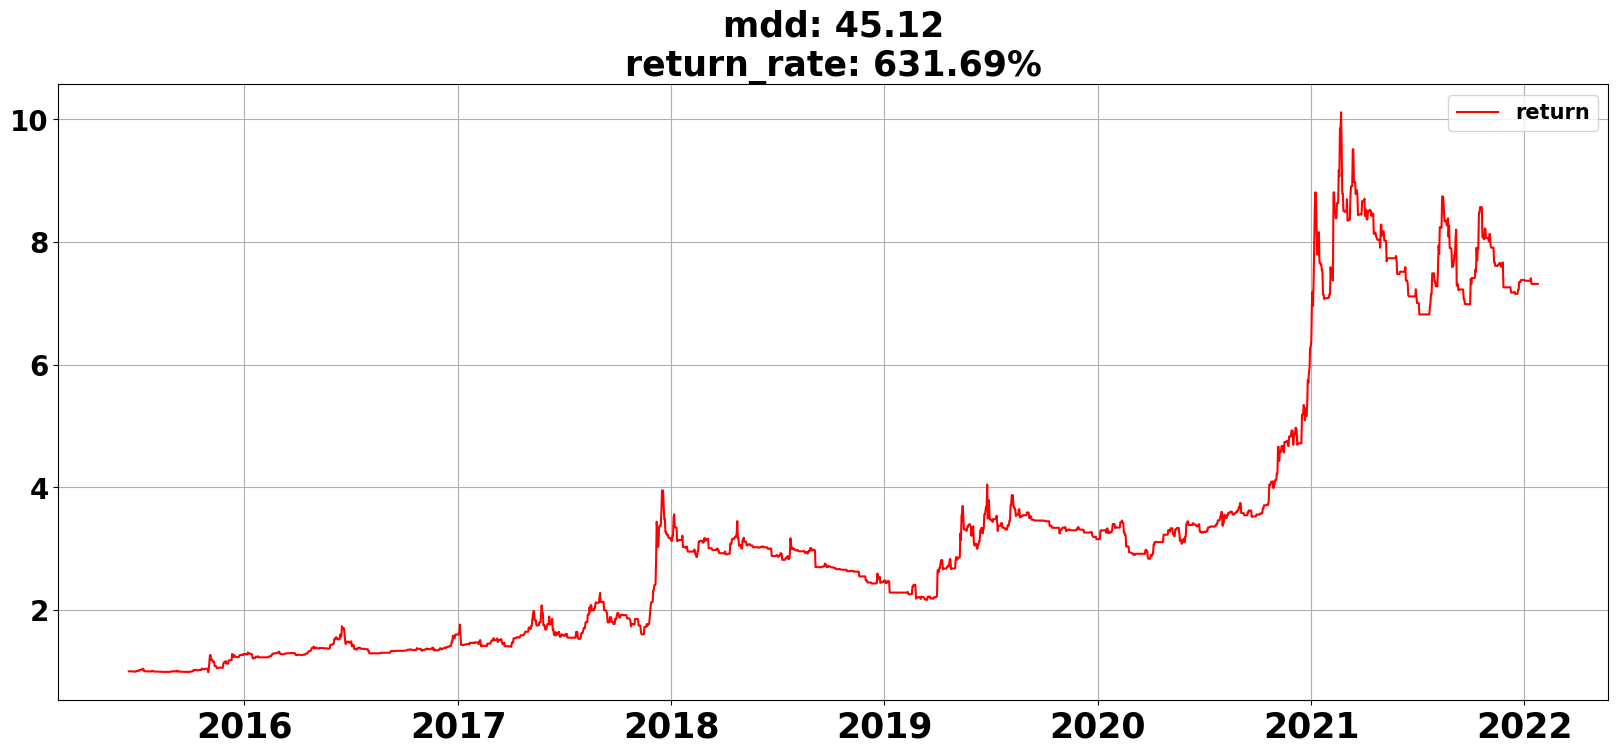

{'trade_rate': ' 25.00%', 'success_rate': ' 52.94%', 'pnl_rate': ' 0.58', 'mdd': ' 6.68%', 'cr': '-4.03%'}


In [46]:
result_df = backtest_ma(result_df)
plot_return(result_df)
analysis_return(result_df)
print(get_result_profit_2(result_df))

In [ ]:
analysis_return(result_df)

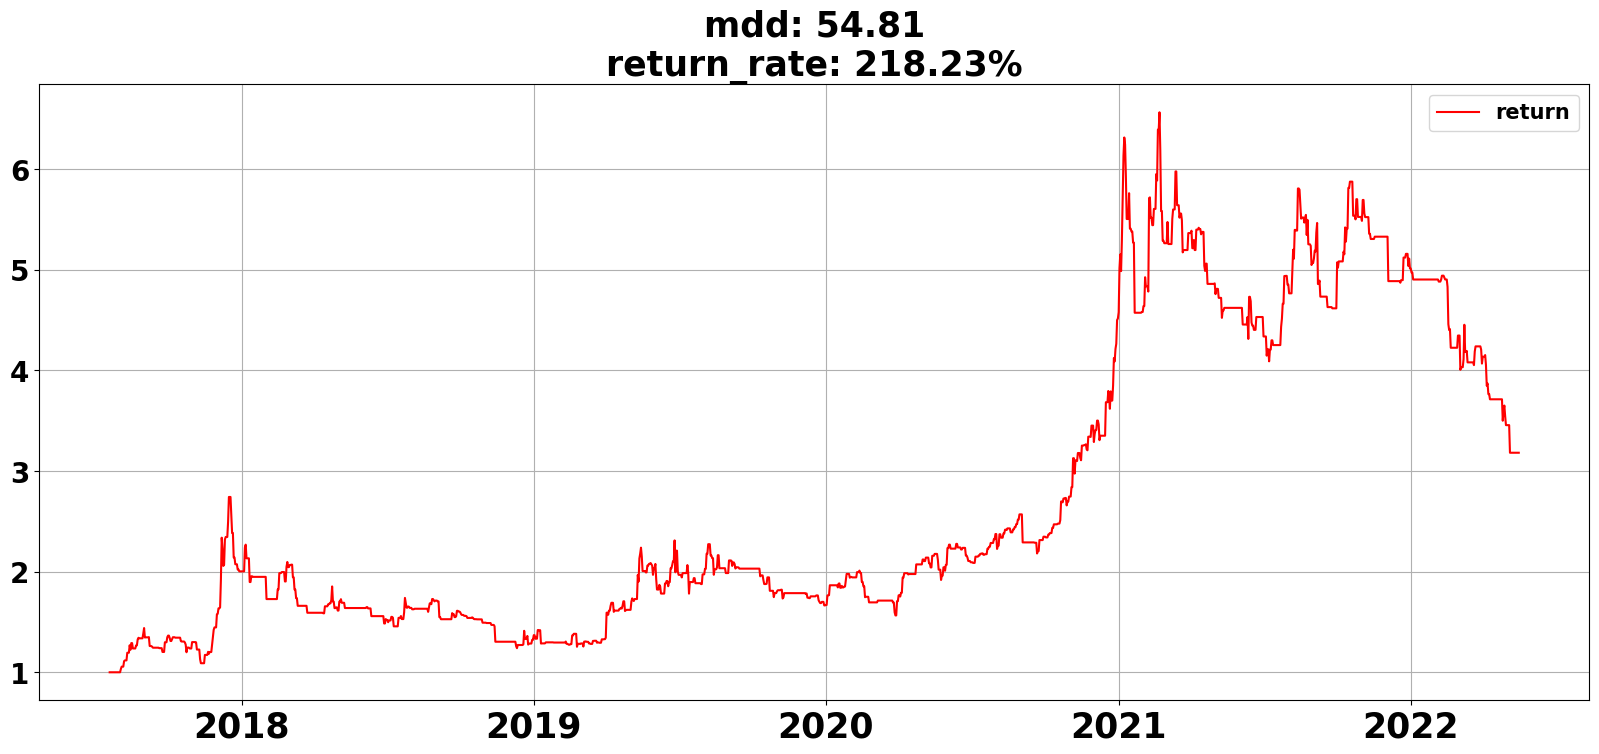

{'trade_rate': ' 37.34%',
 'success_rate': ' 51.98%',
 'pnl_rate': ' 1.20',
 'mdd': ' 54.81%',
 'cr': ' 218.23%'}

In [13]:
result_df = backtest_rsi(result_df)
plot_return(result_df)
analysis_return(result_df)

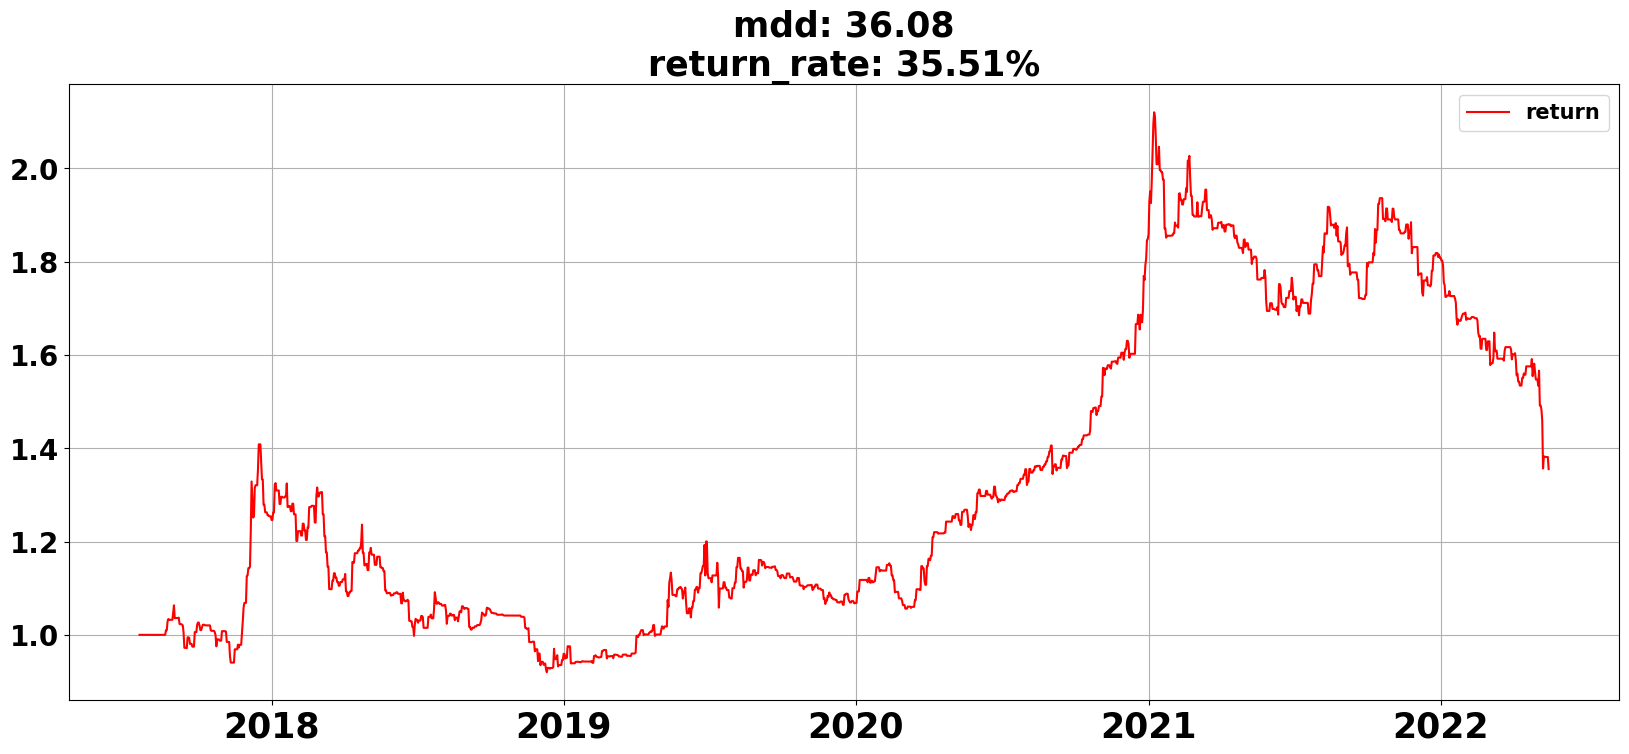

{'trade_rate': ' 49.66%',
 'success_rate': ' 51.20%',
 'pnl_rate': ' 1.09',
 'mdd': ' 36.08%',
 'cr': ' 35.51%'}

In [16]:
result_df = backtest_noise(result_df)
plot_return(result_df)
analysis_return(result_df)

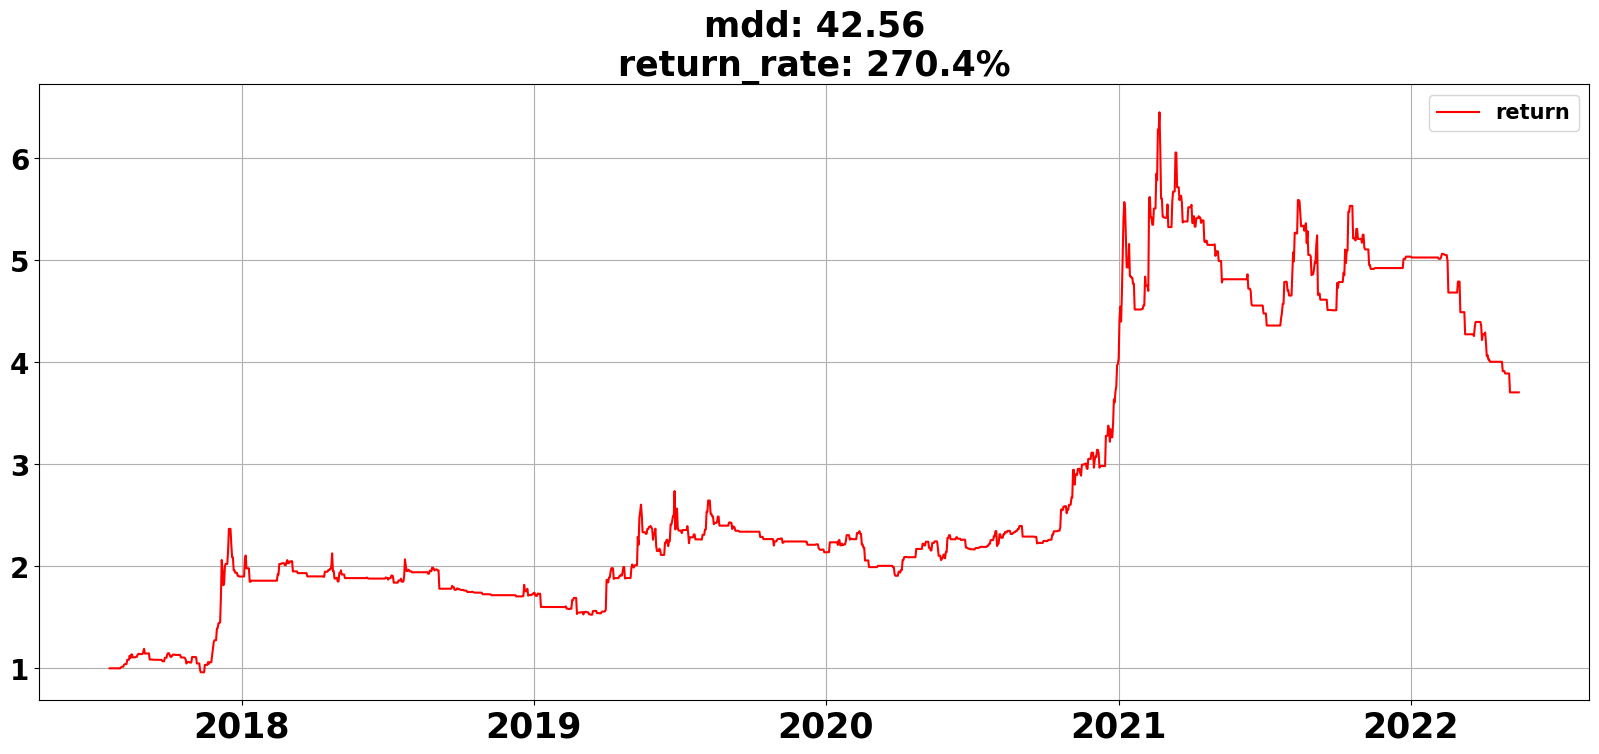

{'trade_rate': ' 34.22%',
 'success_rate': ' 52.07%',
 'pnl_rate': ' 1.28',
 'mdd': ' 42.56%',
 'cr': ' 270.40%'}

In [17]:
result_df = backtest_ma_and_rsi(result_df)
plot_return(result_df)
analysis_return(result_df)

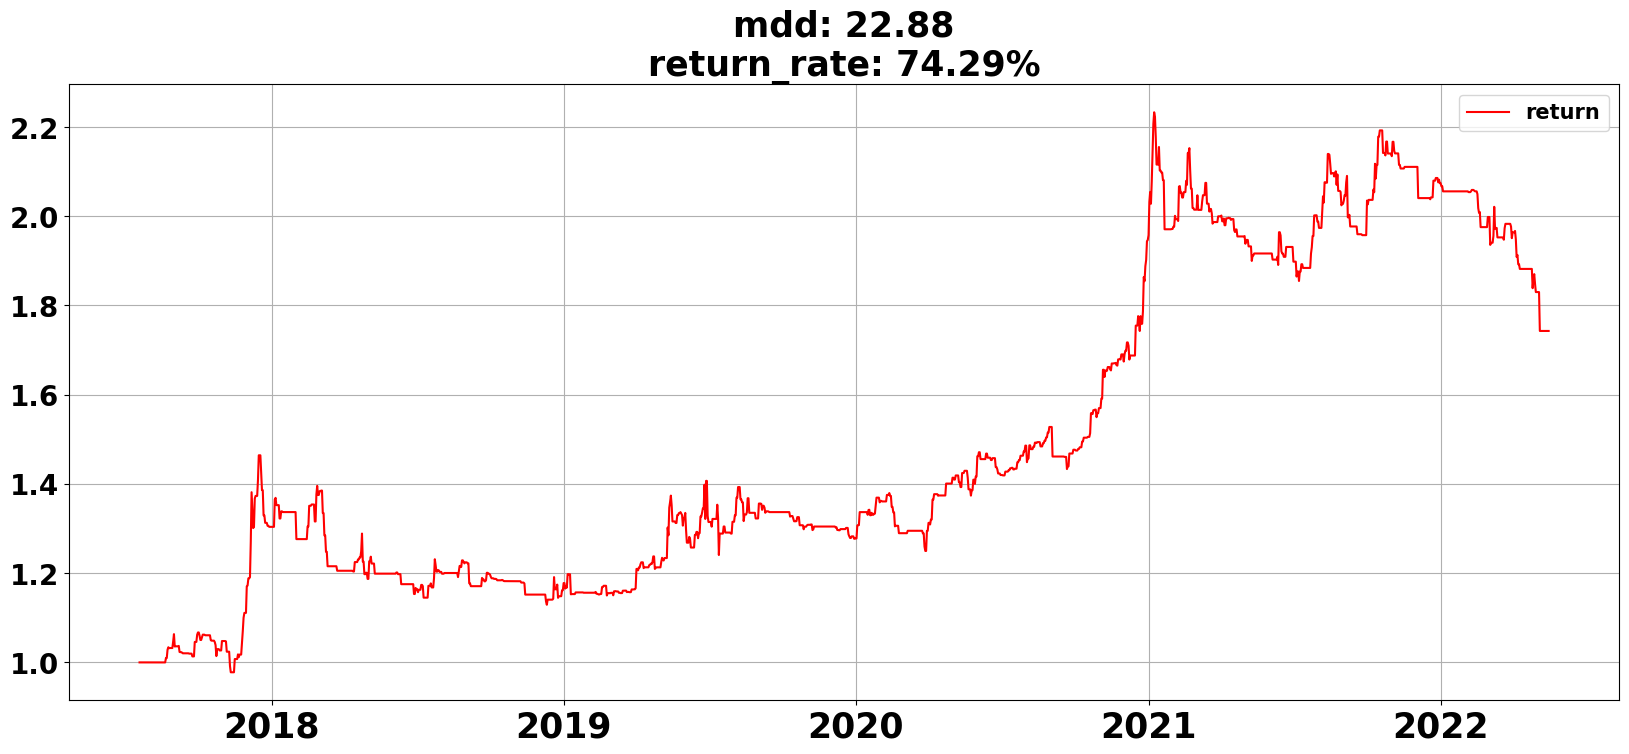

{'trade_rate': ' 36.66%',
 'success_rate': ' 51.86%',
 'pnl_rate': ' 1.20',
 'mdd': ' 22.88%',
 'cr': ' 74.29%'}

In [18]:
result_df = backtest_noise_and_rsi(result_df)
plot_return(result_df)
analysis_return(result_df)

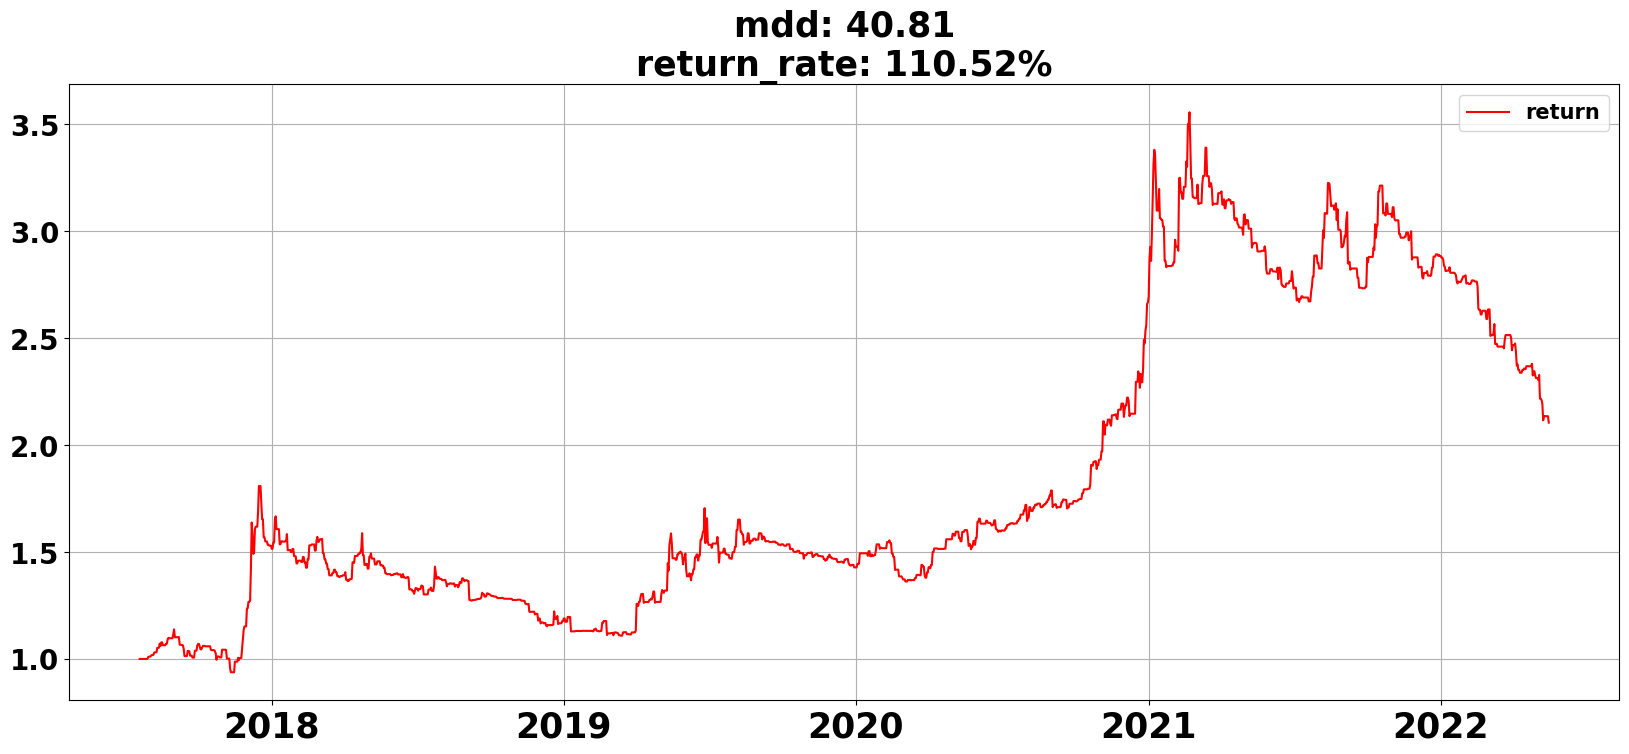

{'trade_rate': ' 50.51%',
 'success_rate': ' 51.46%',
 'pnl_rate': ' 1.17',
 'mdd': ' 40.81%',
 'cr': ' 110.52%'}

In [21]:
result_df = backtest_ma_and_noise(result_df)
plot_return(result_df)
analysis_return(result_df)

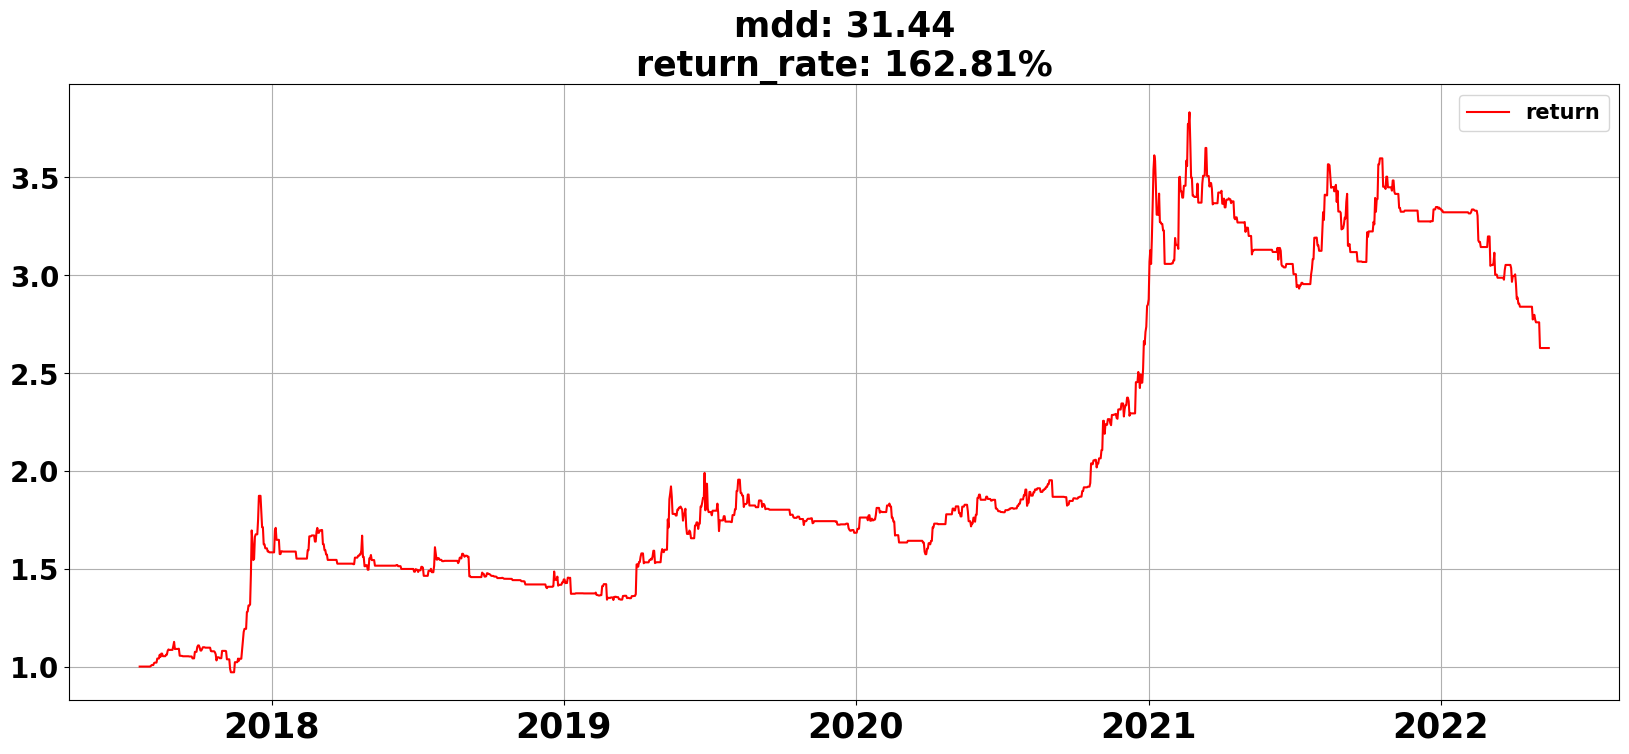

{'trade_rate': ' 37.34%',
 'success_rate': ' 51.98%',
 'pnl_rate': ' 1.25',
 'mdd': ' 31.44%',
 'cr': ' 162.81%'}

In [22]:
result_df = backtest_ma_and_rsi_and_noise(result_df)
plot_return(result_df)
analysis_return(result_df)

2214it [05:59,  6.15it/s]


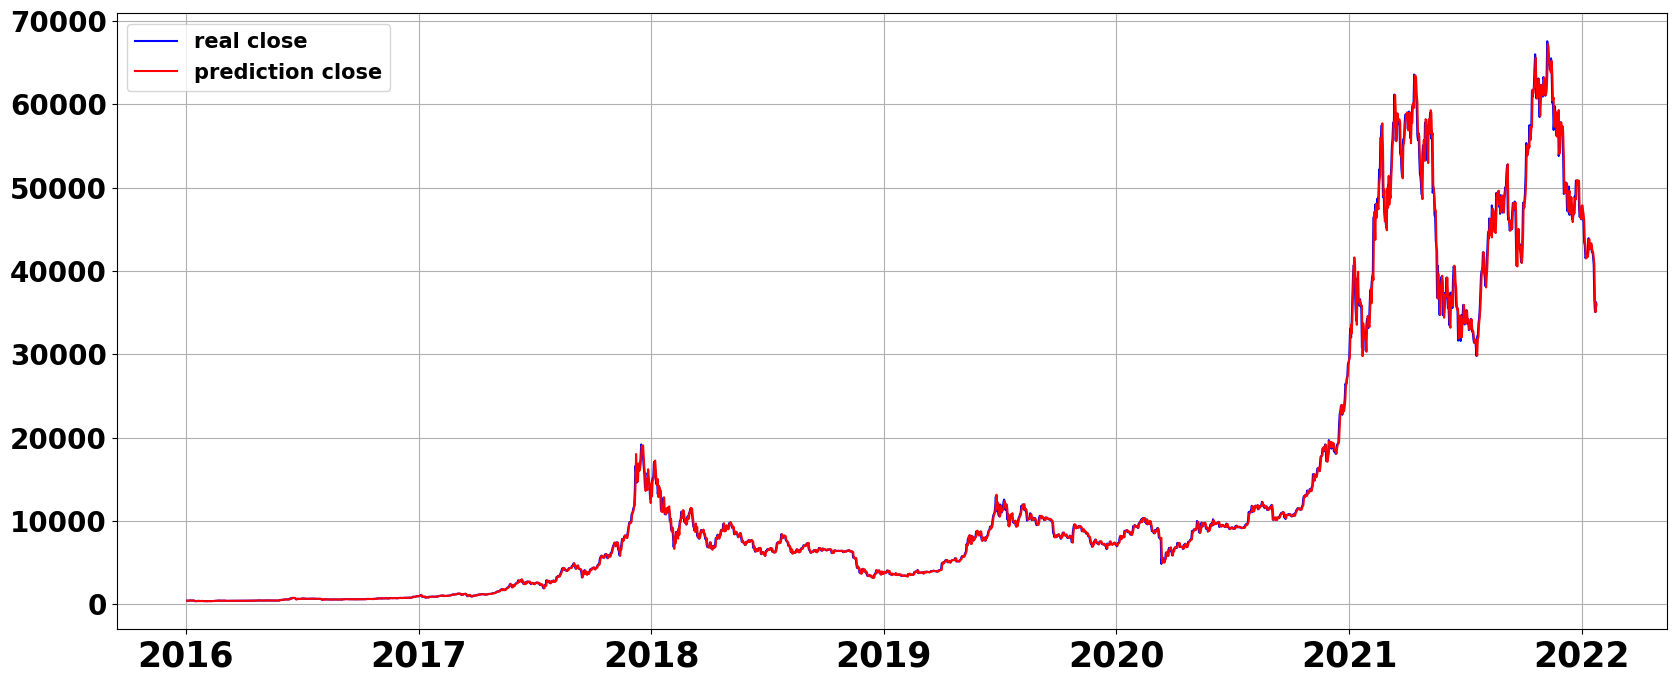

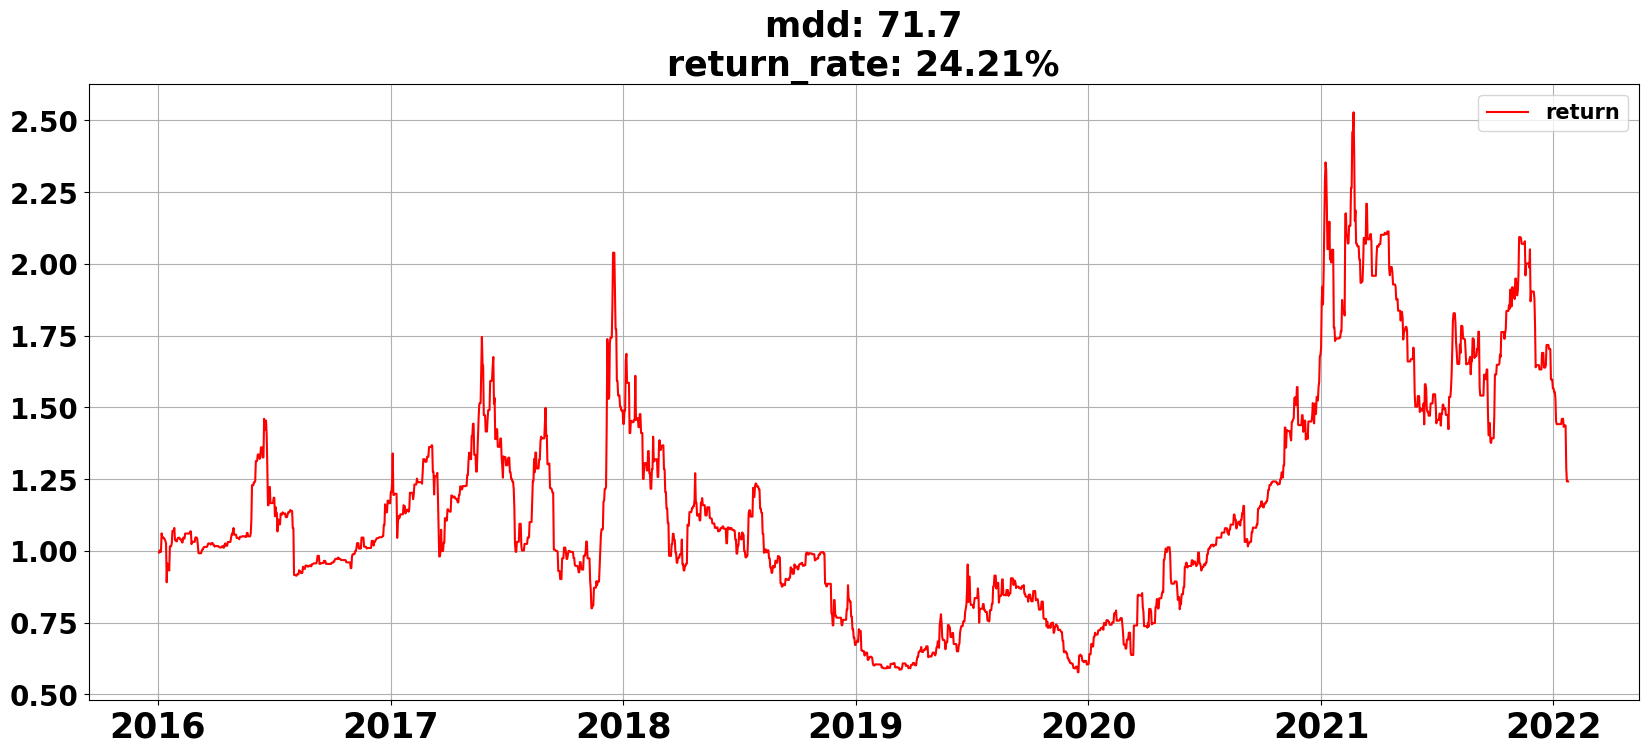

In [54]:
result_df_2 = backtest_arima_1h(df, 300, 1)

503it [00:56,  8.86it/s]


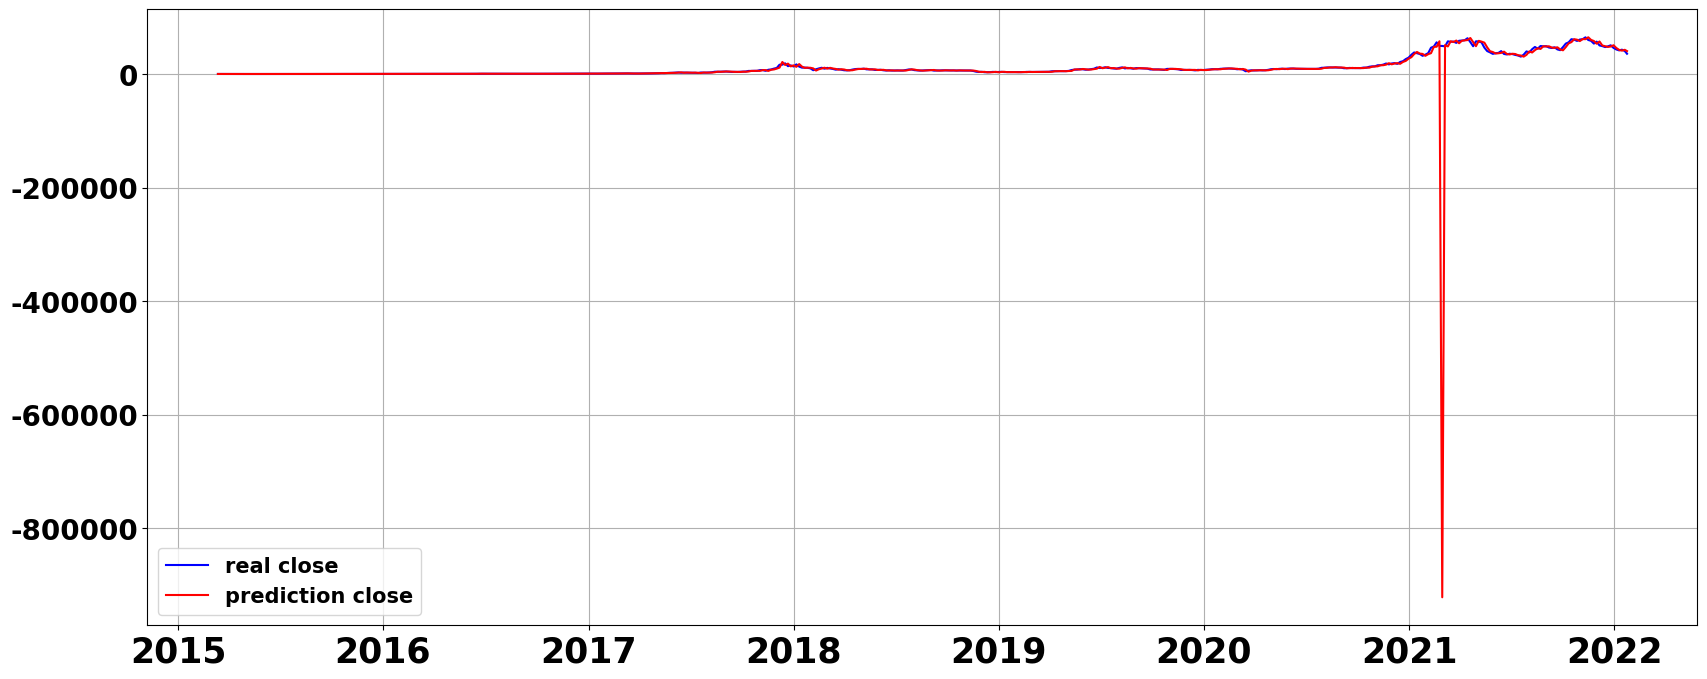

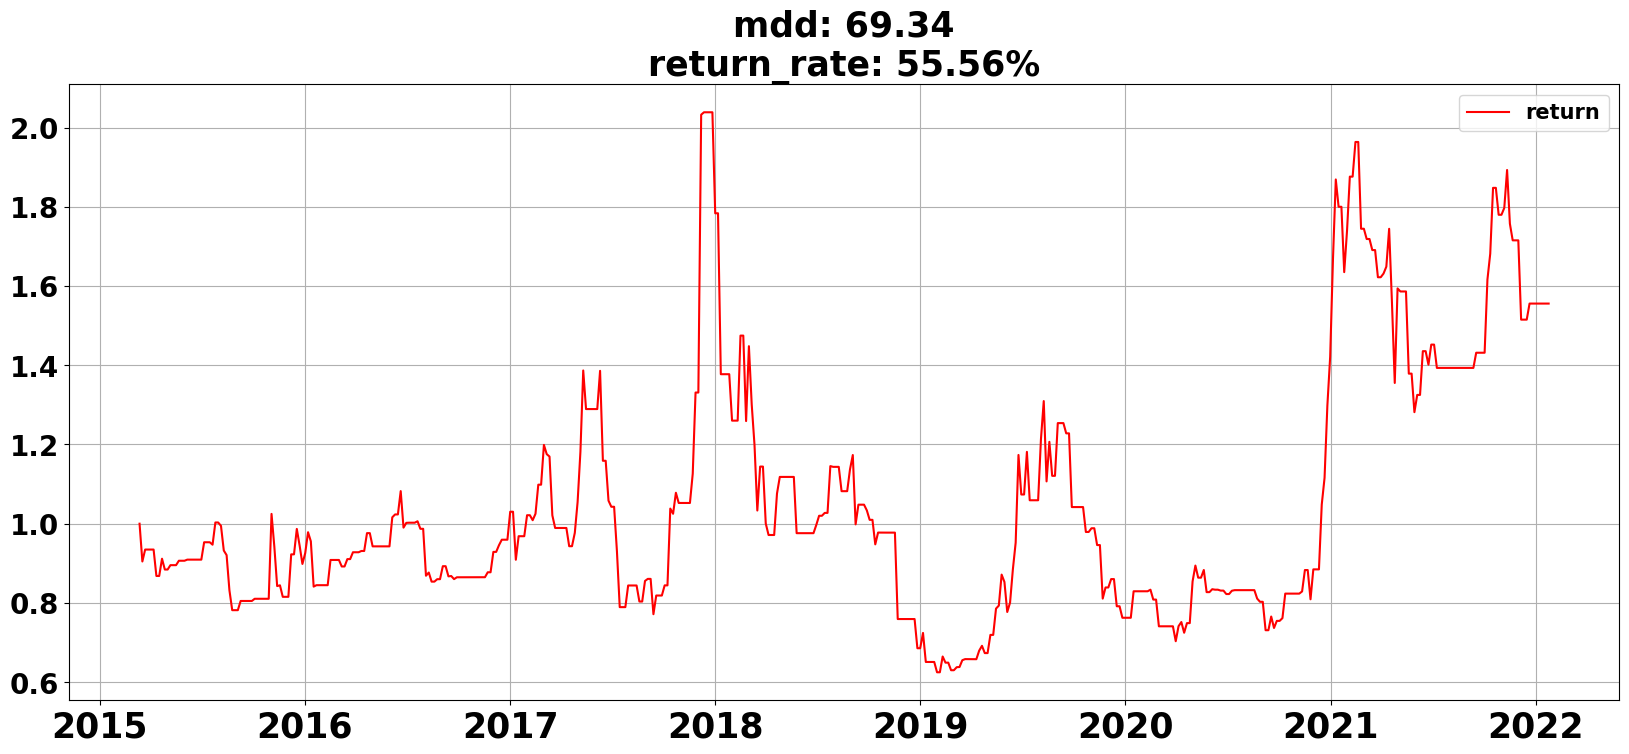

In [52]:
result_df_3 = backtest_arima_1h(df, 100, 5)

483it [01:02,  7.72it/s]


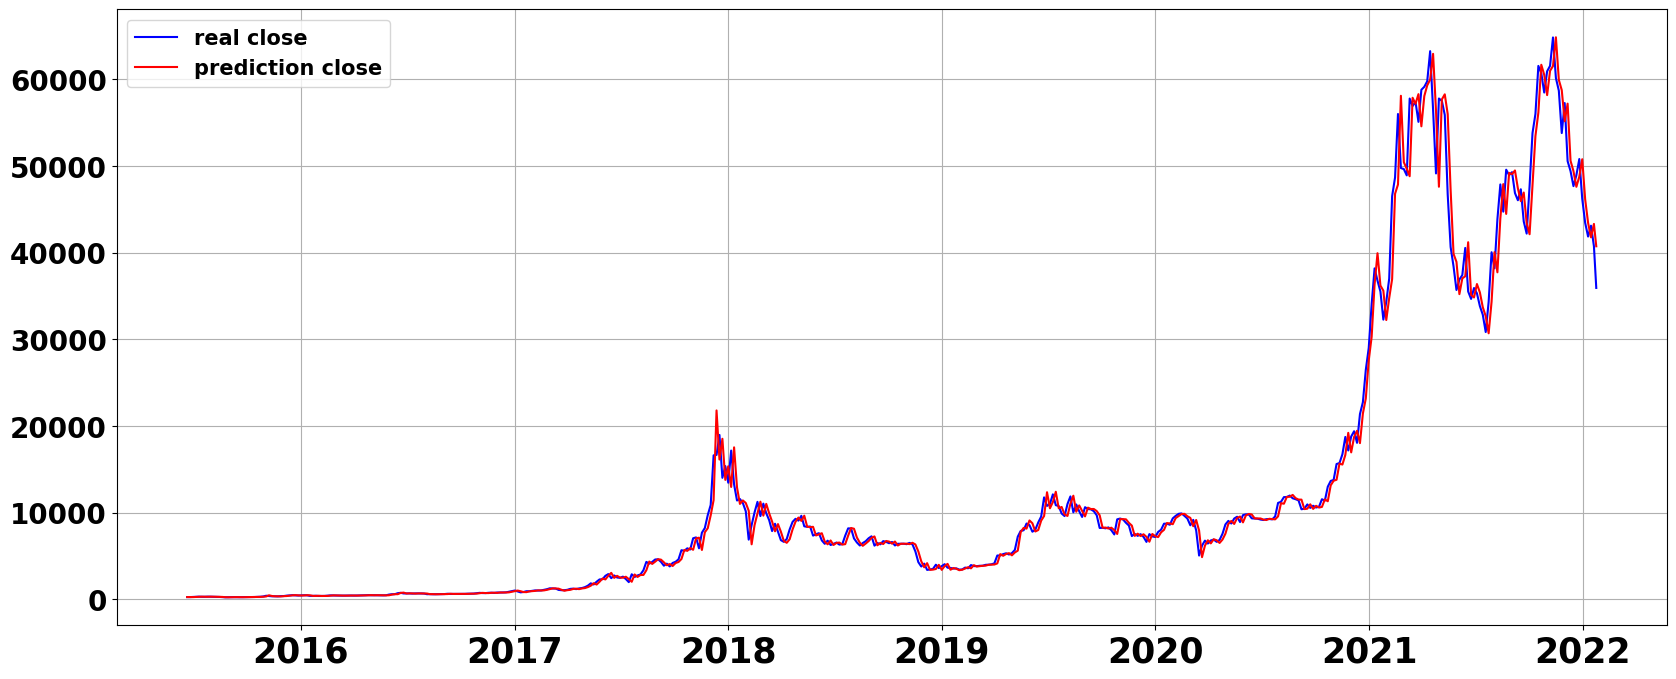

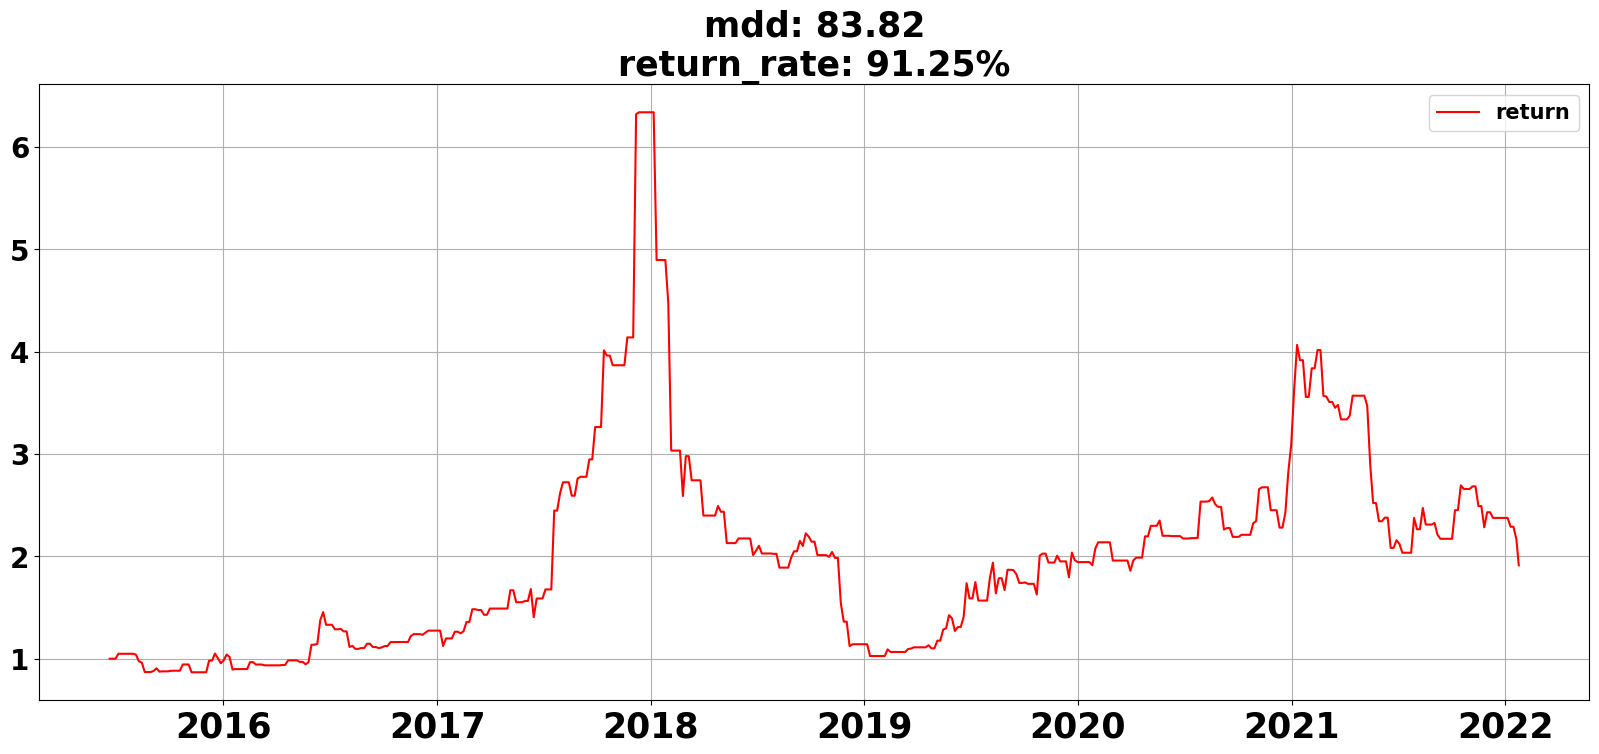

In [53]:
result_df_4 = backtest_arima_1h(df, 200, 5)

In [18]:
analysis_return(result_df)

{'trade_rate': ' 51.58%',
 'success_rate': ' 54.27%',
 'pnl_rate': ' 1.11',
 'mdd': ' 62.15%',
 'cr': ' 79.51%'}

In [ ]:
result_df = backtest_arima_1h(df, 50, 24)

In [34]:
from sklearn.preprocessing import MinMaxScaler

In [33]:
from sklearn.metrics import mean_squared_error
y=result_df['Close']
y_pred=result_df['prediction_close']
RMSE = mean_squared_error(y, y_pred)**0.5
print(RMSE)

838.5482589577512


In [40]:
min_max_scaler = MinMaxScaler()
result_df_s = min_max_scaler.fit_transform(result_df[['Close', 'prediction_close']])
# result_df['prediction_close_s'] = min_max_scaler.fit_transform(list(result_df['prediction_close']))

In [41]:
result_df_s.rename()

array([[5.04697967e-04, 5.28081486e-04],
       [5.38997829e-04, 4.56530135e-04],
       [4.69655684e-04, 5.53205469e-04],
       ...,
       [5.17902969e-01, 5.39031129e-01],
       [5.35758348e-01, 5.23918208e-01],
       [5.30172668e-01, 5.35701598e-01]])

In [43]:
y=result_df_s[0]
y_pred=result_df_s[1]
RMSE = mean_squared_error(y, y_pred)**0.5
print(RMSE)

5.6107381144874705e-05


In [47]:
5.6107 ** (-5)


0.00017985178828473094